<a href="https://colab.research.google.com/github/JonnyElkin/Graph-Representation-Learning-Mini-Project/blob/main/GRL_Mini_project_Question_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GRL Mini-project Question 3

##Set up dependencies

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.13.1+cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 33.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 48.7 MB/s eta 0:00:00


In [ ]:
import torch_geometric
from torch_geometric.datasets import WikiCS

import typing
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GATConv
from torch_geometric.data import Data

## Load the datasets

In [ ]:
undirected_dataset = WikiCS(root="")
directed_dataset = WikiCS(root="",  is_undirected = False)

/usr/local/lib/python3.8/dist-packages/torch_geometric/datasets/wikics.py:38: UserWarning: The WikiCS dataset now returns an undirected graph by default. Please explicitly specify 'is_undirected=False' to restore the old behaviour.
  warnings.warn(
Processing...
Done!
Processing...
Done!


##### Dataset properties

In [ ]:
print("undirected_dataset")
print("number of graphs:\t\t",len(undirected_dataset))
print("number of classes:\t\t",undirected_dataset.num_classes)
print("number of node features:\t",undirected_dataset.num_node_features)
print("number of edge features:\t",undirected_dataset.num_edge_features)

undirected_dataset
number of graphs:		 1
number of classes:		 10
number of node features:	 300
number of edge features:	 0


In [ ]:
print("directed_dataset")
print("number of graphs:\t\t",len(directed_dataset))
print("number of classes:\t\t",directed_dataset.num_classes)
print("number of node features:\t",directed_dataset.num_node_features)
print("number of edge features:\t",directed_dataset.num_edge_features)

directed_dataset
number of graphs:		 1
number of classes:		 10
number of node features:	 300
number of edge features:	 0


#####Dataset shapes

In [ ]:
print(undirected_dataset.data)

Data(x=[11701, 300], edge_index=[2, 431726], y=[11701], train_mask=[11701, 20], val_mask=[11701, 20], test_mask=[11701], stopping_mask=[11701, 20])


/usr/local/lib/python3.8/dist-packages/torch_geometric/data/in_memory_dataset.py:133: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn("It is not recommended to directly access the internal "


In [ ]:
print("edge_index:\t\t",undirected_dataset.data.edge_index.shape)
print(undirected_dataset.data.edge_index)
print("\n")
print("train_mask:\t\t",undirected_dataset.data.train_mask.shape)
print(undirected_dataset.data.train_mask)
print("\n")
print("x:\t\t",undirected_dataset.data.x.shape)
print(undirected_dataset.data.x)
print("\n")
print("y:\t\t",undirected_dataset.data.y.shape)
print(undirected_dataset.data.y)

edge_index:		 torch.Size([2, 431726])
tensor([[    0,     0,     0,  ..., 11700, 11700, 11700],
        [ 3925,  5830,  7248,  ...,  7586,  8454, 11306]])


train_mask:		 torch.Size([11701, 20])
tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [ True, False, False,  ..., False, False, False]])


x:		 torch.Size([11701, 300])
tensor([[-0.0204,  0.0646,  0.0197,  ..., -0.0754, -0.1124,  0.1514],
        [-0.0438, -0.0317, -0.0082,  ..., -0.0658,  0.0643, -0.0588],
        [-0.1127,  0.0098,  0.1422,  ...,  0.1398, -0.0195,  0.0451],
        ...,
        [ 0.0368,  0.0305, -0.0285,  ..., -0.0600, -0.0721,  0.1510],
        [-0.0329,  0.0195, -0.1278,  ..., -0.1751, -0.0754,  0.1974],
        [ 0.0530,  0.0480, -0.0100,  ...,  0.025

##Set up GAT for node classification

In [ ]:
class GAT(nn.Module):
  def __init__(
      self,
      input_dim: int,
      hid_dim: int,
      n_classes: int,
      n_layers: int,
      dropout_ratio: float = 0.3,
      edge_dim: int = None):
    super(GAT, self).__init__()
    """
    Args:
      input_dim: input feature dimension
      hid_dim: hidden feature dimension
      n_classes: number of target classes
      n_layers: number of layers
      dropout_ratio: dropout_ratio
    """

    self.input_dim = input_dim
    self.hid_dim = hid_dim
    self.n_classes = n_classes
    self.n_layers = n_layers
    self.dropout = nn.Dropout(dropout_ratio)
    self.act_fn = nn.ReLU(inplace=False)
    self.edge_dim = edge_dim


    self.layers = nn.ModuleList()

    if self.n_layers == 0:
        self.layers.append(nn.Linear(self.input_dim, self.n_classes))
    else:
      self.layers.append(GATConv(self.input_dim, self.hid_dim, edge_dim =self.edge_dim))
      for i in range(n_layers - 1):
          self.layers.append(GATConv(self.hid_dim, self.hid_dim))
      self.layers.append(nn.Linear(self.hid_dim, self.n_classes))

  def forward(self, X, A, X_edge=None) -> torch.Tensor:

    for l in self.layers:

      if l == self.layers[-1]:  #i.e. if layer is the linear layer
        X = l(X)
        X = F.softmax(X)

      else:
        X = l(X,A, X_edge)
        X = self.act_fn(X)
        X = self.dropout(X)

    return X

  def generate_node_embeddings(self, X, A, X_edge=None) -> torch.Tensor:

    for l in self.layers:

      if l != self.layers[-1]:
        X = l(X,A, X_edge)
        X = self.act_fn(X)
        X = self.dropout(X)

    return X

  
  def param_init(self):

    for l in self.layers:
      l.reset_parameters()


##Training

###Training Function

In [ ]:
def train(
    params: typing.Dict
) -> torch.nn.Module:
  """
    This function trains a node classification model and returns the trained model object.
  """
  # set device
 # device = "cuda" if torch.cuda.is_available() else "cpu"
  device = "cpu"

  if params['model_name'] == 'undirected':
      # load dataset
      data = undirected_dataset.data
      data = data.to(device)

      # Update parameters
      params["n_classes"] = undirected_dataset.num_classes # number of target classes
      params["input_dim"] = undirected_dataset.num_features # size of input features

  elif params['model_name'] == 'directed':
      # load dataset
      data = directed_dataset.data
      data = data.to(device)

      # Update parameters
      params["n_classes"] = directed_dataset.num_classes # number of target classes
      params["input_dim"] = directed_dataset.num_features # size of input features

  elif params['model_name'] == 'bidirection':
      # load dataset
      data = bidirection_dataset.data
      data = data.to(device)

      # Update parameters
      params["n_classes"] = bidirection_dataset.num_classes # number of target classes
      params["input_dim"] = bidirection_dataset.num_features # size of input features
      params["edge_dim"] = 1
  else:
      raise NotImplementedError

  # Set a model
  model = GAT(
    params["input_dim"], 
    params["hid_dim"],
    params["n_classes"],
    params["n_layers"],
    edge_dim =params["edge_dim"]
    ).to(device)


  model.param_init()

  loss_fn = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

  max_epochs = params['epochs']
  count_of_decreases = -1  #as the 1st iter will always add one as prev_ac =0
  early_stopping = params['max_patience']
  epochs = 0

  all_train_data_mask = data.train_mask[:,0]
  for i in range(20):
    all_train_data_mask = all_train_data_mask.logical_or(data.train_mask[:,i]) 

  prev_ac = 0
  train_errors = []
  test_errors = []
  while epochs < max_epochs and count_of_decreases < early_stopping:
      model.train()
      output = model(data.x, data.edge_index, data.edge_attr)
      optimizer.zero_grad()
      loss = loss_fn(output[all_train_data_mask], data.y[all_train_data_mask])


      model.eval()
      val_accuracy = evaluate(model, data, data.test_mask)

      loss.backward()
      optimizer.step()

     # print(val_accuracy)
      if val_accuracy < prev_ac:
        count_of_decreases += 1
      else:
        count_of_decreases = 0
      #if epochs%20 == 0: 
        #print(count_of_decreases)
      prev_ac = val_accuracy
      epochs += 1

      train_errors += [evaluate(model, data, all_train_data_mask)]
      test_errors += [val_accuracy]

  print("Final accuracy:   ", val_accuracy)
  return model, train_errors, test_errors

    
  ## ------ End Solution ------ ##

In [ ]:
def evaluate(
    model,
    data,
    mask
):
    ## ------ Begin Solution ------ ##
    
    output = model(data.x, data.edge_index, data.edge_attr)

    matches = torch.isclose(torch.argmax(output[mask], dim=1), data.y[mask])
    correct = matches.nonzero().size(0)
    test_accuracy = correct/ mask[mask].size(dim=0)
    
    return test_accuracy

    ## ------ End Solution ------ ##

In [ ]:
training_params = {
    "lr": 0.005,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 500,  # number of total training epochs
    "max_patience": 10, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": 1, # number of layers
    "model_name": None,
    "edge_dim": None
}

###Undirected

In [ ]:
torch.manual_seed(123) # set seed 

In [ ]:
training_params["model_name"] = "undirected"
training_params["n_layers"] = 0
model_undirected_l0 , train_errors_undl0, test_errors_undl0 = train(training_params)

<ipython-input-8-3e430023eee6>:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = F.softmax(X)


Final accuracy:    0.5859415084658799


In [ ]:
training_params["model_name"] = "undirected"
training_params["n_layers"] = 1
model_undirected_l1, train_errors_undl1, test_errors_undl1 = train(training_params)

<ipython-input-8-3e430023eee6>:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = F.softmax(X)


Final accuracy:    0.7407217376432359


In [ ]:
training_params["model_name"] = "undirected"
training_params["n_layers"] = 3
model_undirected_l3, train_errors_undl3, test_errors_undl3 = train(training_params)

<ipython-input-8-3e430023eee6>:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = F.softmax(X)


Final accuracy:    0.7417479049085001


###Directed

In [ ]:
training_params["model_name"] = "directed"
training_params["n_layers"] = 0
model_directed_l0, train_errors_dl0, test_errors_dl0 = train(training_params)

<ipython-input-8-3e430023eee6>:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = F.softmax(X)


Final accuracy:    0.5855994527107918


In [ ]:
training_params["model_name"] = "directed"
training_params["n_layers"] = 1
model_directed_l1, train_errors_dl1, test_errors_dl1 = train(training_params)

<ipython-input-8-3e430023eee6>:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = F.softmax(X)


Final accuracy:    0.7426030442962203


In [ ]:
training_params["model_name"] = "directed"
training_params["n_layers"] = 3
model_directed_l3, train_errors_dl3, test_errors_dl3 = train(training_params)

<ipython-input-8-3e430023eee6>:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = F.softmax(X)


Final accuracy:    0.7556011629895673


##Visualisation

###Node Embeddings

In [ ]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
def dimension_reduction(model: nn.Module, dataset) -> pd.DataFrame:
  """
    Args:
      model: model object for generating features
    
    Return:
      pd.DataFrame: A data frame that has 'dimension 1', 'dimension 2', and 'labels' as a column
  """
    ## ------ Begin Solution ------ ##

  # load dataset
  data = dataset.data

  tsne = TSNE()
  embeddings = model.generate_node_embeddings(data.x, data.edge_index, data.edge_attr)
  masked_embeddings = embeddings[data.val_mask[:,0]]

  reduced = tsne.fit_transform(masked_embeddings.detach().cpu().numpy())

  y = data.y[data.val_mask[:,0]]
  y = y[:, None].detach().cpu().numpy()

  combined = np.concatenate((reduced, y), axis=1)

  df = pd.DataFrame(combined).astype("float").rename(columns={0: "dimension 1", 1: "dimension 2", 2: "labels"})
  
  return df
    ## ------ End Solution ------ ##

In [ ]:
feature_dict = {
    "undirected_0_layer": dimension_reduction(model_undirected_l0, undirected_dataset),
    "undirected_1_layer": dimension_reduction(model_undirected_l1, undirected_dataset),
    "undirected_3_layer": dimension_reduction(model_undirected_l3, undirected_dataset),

    "directed_0_layer": dimension_reduction(model_directed_l0, directed_dataset),
    "directed_1_layer": dimension_reduction(model_directed_l1, directed_dataset),
    "directed_3_layer": dimension_reduction(model_directed_l3, undirected_dataset),

}

/usr/local/lib/python3.8/dist-packages/torch_geometric/data/in_memory_dataset.py:133: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn("It is not recommended to directly access the internal "
/usr/local/lib/python3.8/dist-packages/torch_geometric/data/in_memory_dataset.py:133: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn("It is not recommended to directly access the internal "
/usr/local/lib/pytho

In [ ]:
def visualise(feature_dict: typing.Dict) -> None:
    ## ------ Begin Solution ------ ##
  fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(10, 20))

  keys = feature_dict.keys()
  for i, key in enumerate(feature_dict):
    df = feature_dict[key]

    ax[i].scatter(df['dimension 1'], df['dimension 2'], c=df['labels'])
    ax[i].set_title(key+ ':   dimension 1 vs dimension 2') 

  #  ax[i, 1].scatter(df['dimension 2'], df['labels'])
  #  ax[i, 1].set_title(key+  ':   dimension 2 vs labels') 

    ## ------ End Solution ------ ##

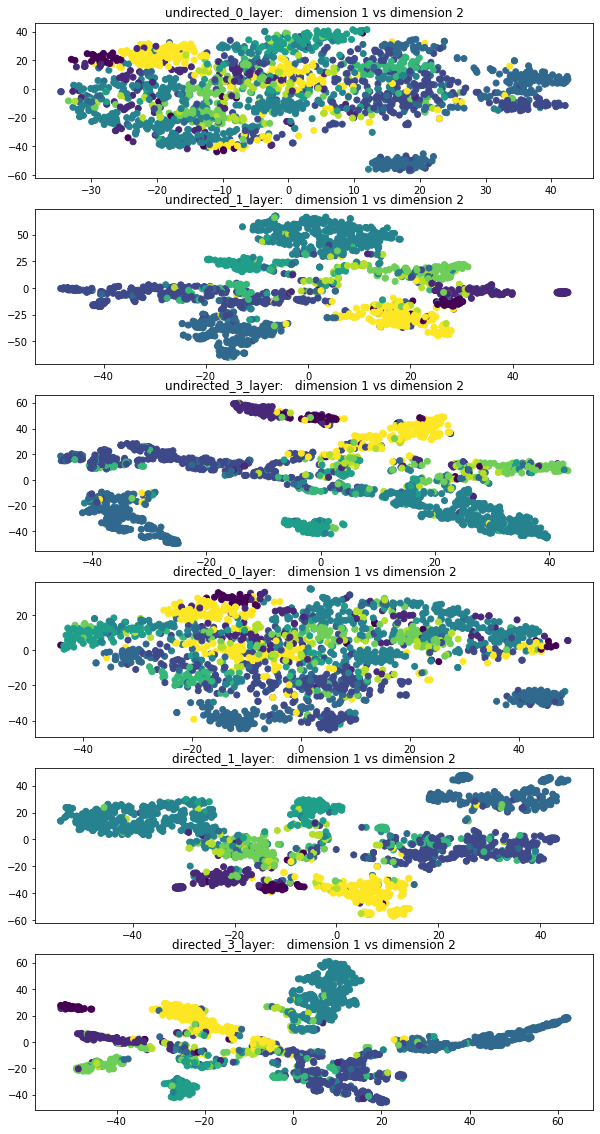

In [ ]:
visualise(feature_dict)

###Learning Curves

In [ ]:
curve_dict = {
    "undirected_0_layer": (train_errors_undl0, test_errors_undl0),
    "undirected_1_layer": (train_errors_undl1, test_errors_undl1),
    "undirected_3_layer": (train_errors_undl3, test_errors_undl3),

    "directed_0_layer": (train_errors_dl0, test_errors_dl0),
    "directed_1_layer": (train_errors_dl1, test_errors_dl1),
    "directed_3_layer": (train_errors_dl3, test_errors_dl3),

}

In [ ]:
def plot_learning(curve_dict: typing.Dict) -> None:
  fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))
  colours = ['red', 'blue']
  types = ['Undirected', 'Directed']
  titles = ['0 layer', '1 layer', '3 layer']
  keys = feature_dict.keys()
  for i, key in enumerate(feature_dict):
    pair = curve_dict[key]

    ax[i%3].plot(pair[0], label=types[i//3]+' Training Accuracy', linestyle='dashed', color=colours[i//3])
    ax[i%3].plot(pair[1], label=types[i//3]+' Test Accuracry', linestyle='solid', color=colours[i//3])

    ax[i%3].set_title(titles[i%3]) 
    leg = ax[i%3].legend(loc='lower right')

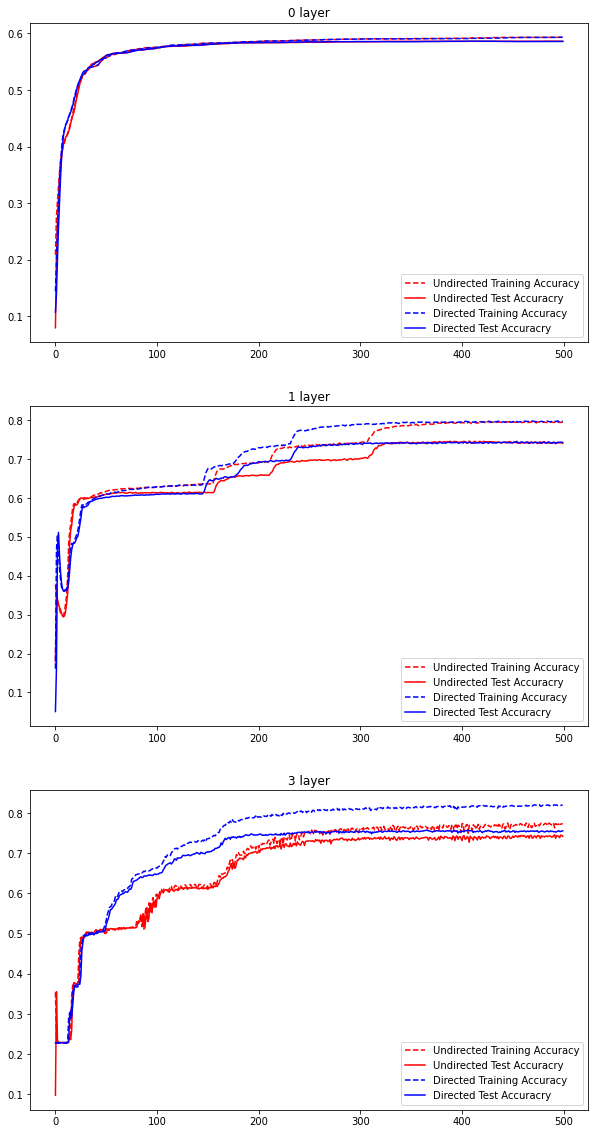

In [ ]:
plot_learning(curve_dict)

##With Edge Attributes model

(Couldn't find the bug)

In [ ]:
list_of_undirected = torch.transpose(undirected_dataset.data.edge_index, 0, 1).tolist()
list_of_directed = torch.transpose(directed_dataset.data.edge_index, 0, 1).tolist()

/usr/local/lib/python3.8/dist-packages/torch_geometric/data/in_memory_dataset.py:133: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn("It is not recommended to directly access the internal "


In [ ]:
"""
edge_attr = torch.zeros((431726,2), dtype=int)


for i, edge in enumerate(list_of_undirected):
  if edge in list_of_directed:
    edge_attr[i][0] += 1

  if [edge[1], edge[0]] in list_of_directed:
    edge_attr[i][1] += 1

"""


'\nedge_attr = torch.zeros((431726,2), dtype=int)\n\n\nfor i, edge in enumerate(list_of_undirected):\n  if edge in list_of_directed:\n    edge_attr[i][0] += 1\n\n  if [edge[1], edge[0]] in list_of_directed:\n    edge_attr[i][1] += 1\n\n'

In [ ]:

#bidirection_dataset = WikiCS(root="")
#bidirection_dataset.data.edge_attr = edge_attr


In [ ]:
"""
print("bidirection_dataset")
print("number of graphs:\t\t",len(bidirection_dataset))
print("number of classes:\t\t",bidirection_dataset.num_classes)
print("number of node features:\t",bidirection_dataset.num_node_features)
print("number of edge features:\t",bidirection_dataset.num_edge_features)
"""

'\nprint("bidirection_dataset")\nprint("number of graphs:\t\t",len(bidirection_dataset))\nprint("number of classes:\t\t",bidirection_dataset.num_classes)\nprint("number of node features:\t",bidirection_dataset.num_node_features)\nprint("number of edge features:\t",bidirection_dataset.num_edge_features)\n'

###Train Bidirection model

In [ ]:
#training_params["model_name"] = "bidirection"
#model_bidirection = train(training_params)